In [71]:
import numpy as np
import pandas as pd
import novosparc
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [72]:
data_path = 'raw/expr_matrix_10day_log_normalized.txt'   # 11566 cells and 2000 genes
# data_path = 'raw/SCTransform_10day_pesudocell_matrix.txt'
# data_path = 'SCTransformed_10day_3000var.genes_pesudocell.txt'
output_folder = 'out'
tissue_path = 'raw/myshape.npy'
hvg_path = 'raw/high_variable_genes_10day.txt'
location_marker = 'raw/dge_full.txt'
atlas_path = 'raw/atlas.txt'

In [73]:
nn = 5
alpha_linear = 0.3
cell_nb = 1000
### select 3 markers that have no overlap
insitu_genes = ['SMED30025697','SMED30033119'] #,'SMED30004921','SMED30017714','SMED30026600'

In [74]:
# load dataset:  expression matrix   col-gene,row-cell
dataset = novosparc.io.load_data(data_path)
dataset.shape

KeyboardInterrupt: 

In [ ]:
# just to view gene names and the matrix
gene_names = np.asarray(dataset.var.index.tolist())

In [ ]:
# ### set average gene expr close to 1
# ### not sure about its impact, but perhaps it could get things closer to marker's binary value????

# my = dataset.X
# for i in range(my.shape[0]):
#     divide_by = np.average(my[i][my[i]>0])
#     my[i] = my[i]/divide_by+0.00000001   
# dataset.X = my

In [44]:
# save the set to dataset.raw
dataset.raw = dataset
# select only genes in hvg_list
dataset, hvg = novosparc.pp.subset_to_hvg(dataset, hvg_file = hvg_path) # dataset[:,dataset.var.index.isin(gene_list)], gene_list
dataset.shape

In [46]:
print(np.max(dataset.X),np.min(dataset.X),np.average(dataset.X))

8.524791 0.0 0.05542864


### load target space (location)

In [75]:
# load target space
# locations = novosparc.geometry.create_target_space_from_image(tissue_path) #
locations = np.load(tissue_path)
raw_location_shape = locations.shape[0]
raw_location_shape

66203

In [76]:
location_3d = []
for i in range(10):
    for j in range(len(locations)):
        item = [locations[j][0],locations[j][1],i*3]
        location_3d.append(item) 
location_3d = np.array(location_3d)
piled_location_shape = location_3d.shape[0]
piled_location_shape

662030

In [77]:
# subsample the locations to save effort -- low resolution now
cell_nb = cell_nb #dataset.shape[0] * 5
seed = np.random.choice(location_3d.shape[0], cell_nb,replace=False)  ### -------- later to select markers   3000  11566  cell_nb
location_3d = location_3d[seed, :]
location_3d.shape

(1000, 3)

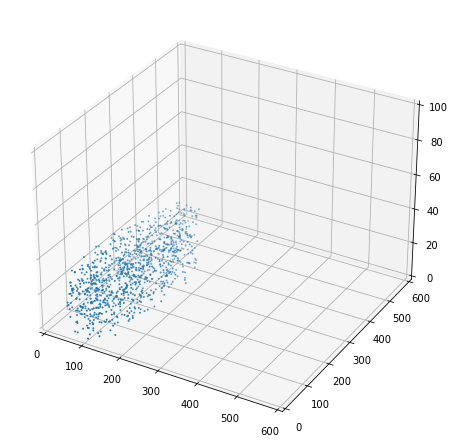

In [78]:
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlim([0,600])
ax.set_ylim([0,600])
ax.set_zlim([0,100])
x = location_3d[:,0]
y = location_3d[:,1]
z = location_3d[:,2]
ax.scatter(x,y,z,s=1)
plt.show()

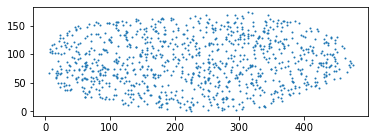

In [79]:
plt.figure(figsize=(6,2))
plt.scatter(location_3d[:, 1], location_3d[:, 0],s=1)
plt.show()

### Reconstruction
https://github.com/rajewsky-lab/novosparc/blob/master/reconstruct_drosophila_embryo_tutorial.ipynb

In [80]:
#Reconstruct the tissue de novo/with marker
tissue = novosparc.cm.Tissue(dataset=dataset, locations=location_3d, output_folder=output_folder)

In [81]:
if insitu_genes==[]:
    insitu_genes = np.genfromtxt(atlas_path, usecols=range(29), dtype='str', max_rows=1)
else:
    pass

In [82]:
# find indices of marker genes in dge dataset
gene_names = tissue.gene_names     
markers_in_sc = np.array([], dtype='int')
markers_in_sc_name = []
for marker in insitu_genes:   
    marker_index = np.where(gene_names == marker)[0]
    if len(marker_index) > 0:
        markers_in_sc = np.append(markers_in_sc, marker_index[0])
        markers_in_sc_name.append(marker)

In [83]:
atlas_nb = markers_in_sc.shape[0]
atlas_nb

2

In [84]:
# load atlas matrix
# make sure atlas_matrix.shape[1]==tissue.dge[:, markers_in_sc].shape[1] (or dataset.dge)
# also don't forget to extract points that used in locations only  (seed)
atlas_matrix = pd.read_csv(atlas_path,sep='\t')
atlas_matrix = atlas_matrix[markers_in_sc_name]
atlas_matrix = atlas_matrix.to_numpy()

atlas_3d = np.zeros((piled_location_shape,atlas_nb))
atlas_3d[5*raw_location_shape:6*raw_location_shape] = atlas_matrix   # it was assigned in previous
atlas_matrix = atlas_3d[seed,:]
atlas_matrix.shape

(1000, 2)

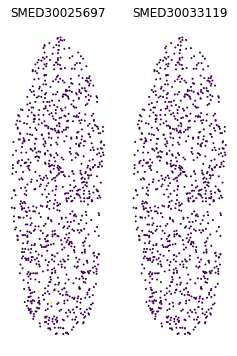

In [67]:
# to show status of the input atlas
mylen=len(markers_in_sc_name)
plt.figure(figsize=(2*mylen,6))
for i in range(mylen):
        plt.subplot(1,mylen,i+1)        
        expr_val = atlas_matrix[:,i]       
        plt.scatter(location_3d[:, 0], location_3d[:, 1], c=expr_val, s=1)
        plt.title(markers_in_sc_name[i])
        plt.axis('off')
plt.show()

In [ ]:
tissue.setup_reconstruction(markers_to_use=markers_in_sc, insitu_matrix=atlas_matrix, num_neighbors_s=nn, num_neighbors_t=nn)

In [ ]:
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=5e-3) ########调试alpha_linear，似乎是marker gene 的重要程度[0-1]，0是不加marker

In [ ]:
import time
t1 = time.time()
tissue.calculate_spatially_informative_genes()
t2 = time.time()
print(t2-t1)

### show result

In [ ]:
sdge_hvg = tissue.sdge

In [ ]:
sdge = tissue.calculate_sdge_for_all_genes()
sdge.shape

In [ ]:
# plot some genes
gene_list_to_plot = [
    'SMED30011970', #eye and head, dd_4427
    'SMED30030642', #pharynx
    'SMED30001882',#brain and phx
    'SMED30005457', #super strong; big cells around the gut
    'SMED30000013', #gut
    'SMED30010123', #protonephridia
    'SMED30016244', #secretory cells?
    'SMED30011490', #epithelium     
]

In [ ]:
list_marker = [g in tissue.gene_names for g in gene_list_to_plot]
list_index = np.nonzero(list_marker)[0]
gene_list_to_plot = [gene_list_to_plot[i] for i in list_index]
# gene_list_to_plot

In [ ]:
gene_dict = {
    'SMED30011970':'eye and head',
    'SMED30030642':'pharynx',
    'SMED30001882':'brain and phx',
    'SMED30005457':'big cells-gut(++)',
    'SMED30000013':'gut',
    'SMED30010123':'protonephridia',
    'SMED30016244':'secretory cells',
    'SMED30011490':'epithelium'
}


In [ ]:
mylen=len(gene_list_to_plot)
plt.figure(figsize=(2*mylen,6))

for i in range(len(gene_list_to_plot)):
        plt.subplot(1,mylen,i+1)        
        expr_val = sdge[np.argwhere(gene_names == gene_list_to_plot[i])[0], :].flatten()        
        plt.scatter(locations[:, 0], locations[:, 1], c=expr_val, s=3)
        plt.title(gene_dict[gene_list_to_plot[i]])
        plt.axis('off')
plt.show()

### show input markers's perdiction

In [ ]:
ig_marker = [ig in gene_names for ig in insitu_genes]
ig_index = np.nonzero(ig_marker)[0]
ig_list_to_plot = [insitu_genes[i] for i in ig_index]
# ig_list_to_plot

In [ ]:
len(ig_list_to_plot)

In [ ]:
mylen=len(ig_list_to_plot)
plt.figure(figsize=(2*mylen,6))
for i in range(mylen):
        plt.subplot(1,mylen,i+1)        
        expr_val = sdge[np.argwhere(gene_names == ig_list_to_plot[i])[0], :].flatten()        
        plt.scatter(location_3d[:, 0], location_3d[:, 1], c=expr_val, s=3)
        plt.title(ig_list_to_plot[i])
        plt.axis('off')
plt.show()

In [ ]:
# to show status of the input atlas
mylen=len(ig_list_to_plot)
plt.figure(figsize=(2*mylen,6))
for i in range(mylen):
        plt.subplot(1,mylen,i+1)        
        expr_val = atlas_matrix[:,i]       
        plt.scatter(location_3d[:, 0], location_3d[:, 1], c=expr_val, s=3)
        plt.title(ig_list_to_plot[i])
        plt.axis('off')
plt.show()